# Traps experiments

This first experiment is about converting a single row; single trap in the column

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'



### This is the kernel I use

This is a best fit from Bijan's code for 1 single type of traps. Done by running the "1 electron" mode of Bijan's code with 1 single trap along that column, for a large number of times, and fit the average resulting image.

In [17]:
arr = np.arange(20) # that's pixels
b = 0.25
kernel = np.exp(-b*arr)
kernel /= np.sum(kernel)

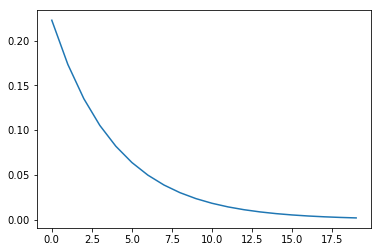

In [18]:
plt.plot(arr,kernel)
plt.show()

### Create fake data

Just testing things out.

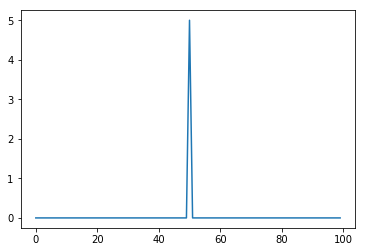

In [19]:
fakecolumn = np.zeros(100)
fakecolumn[50] = 5
plt.plot(fakecolumn)
plt.show()

### Brute force treatment

This is the only I could come up with on small timescales, but honestly it is not very clever and quite brute force.

Effectively replaces the flux density of each pixel by an exponential tail. Need to make the column larger by the kernel size, and then crop it later.

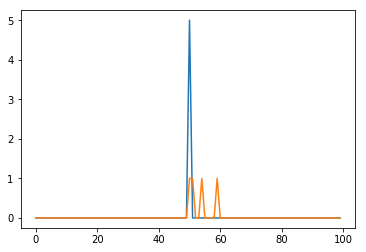

In [21]:
final = np.zeros(120)
for i in range(len(final)-len(kernel)):
    final[i:i+len(kernel)] += np.random.poisson(fakecolumn[i]*kernel)
plt.plot(fakecolumn,label='Original')
plt.plot(final[:100],label='Convolved')
plt.show()

## Application to images

crispy - INFO - Read data from HDU 1 of ../../../crispy/Inputs/os5_spc_064_targetstar_IFS.fits


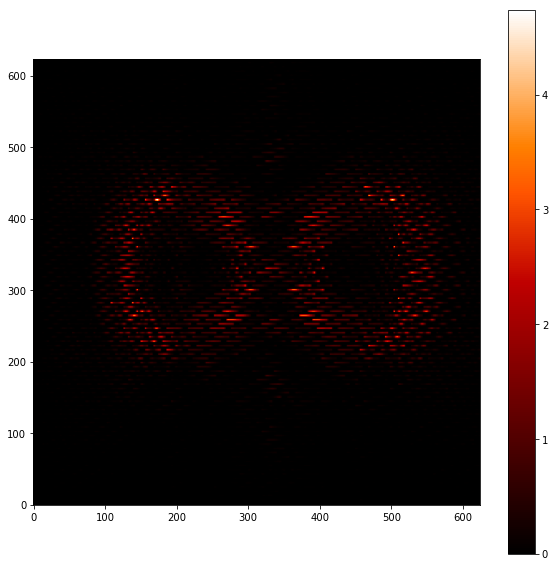

In [24]:
# load image with crispy module, but you can put any array that you want
from crispy.tools.image import Image
img = Image('../../../crispy/Inputs/os5_spc_064_targetstar_IFS.fits')
img.data = img.data[200:-200,200:-200]
# just to play with some fluxes for now, the absolute scale is meaningless for this test
img.data*=1000

plt.figure(figsize=(10,10))
plt.imshow(img.data, cmap='gist_heat')
plt.colorbar()
plt.show()

### Seed random traps

Just create the traps locations randomly.

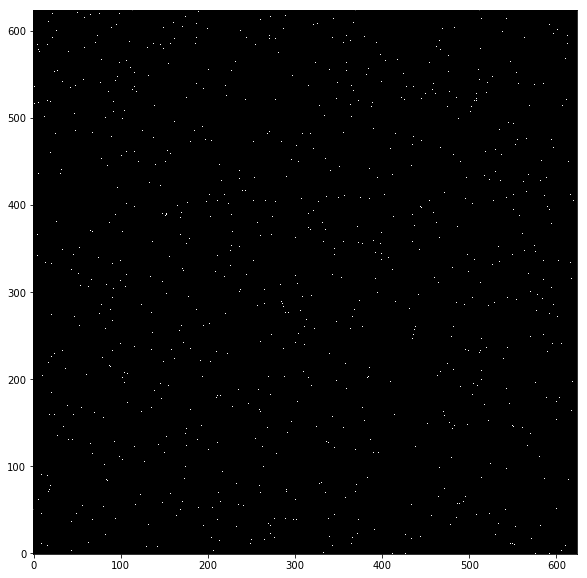

In [25]:
Ntraps = 1000
imgshape = img.data.shape
traps_X = np.random.randint(0,imgshape[0],Ntraps)
traps_Y = np.random.randint(0,imgshape[1],Ntraps)
traps = np.zeros(imgshape)
traps[traps_Y,traps_X] = 1
plt.figure(figsize=(10,10))
plt.imshow(traps, cmap='gist_heat')
plt.show()

### Assume that parallel register is on the top of the image (pixels have tail towards the bottom, in these images)

Go column by column

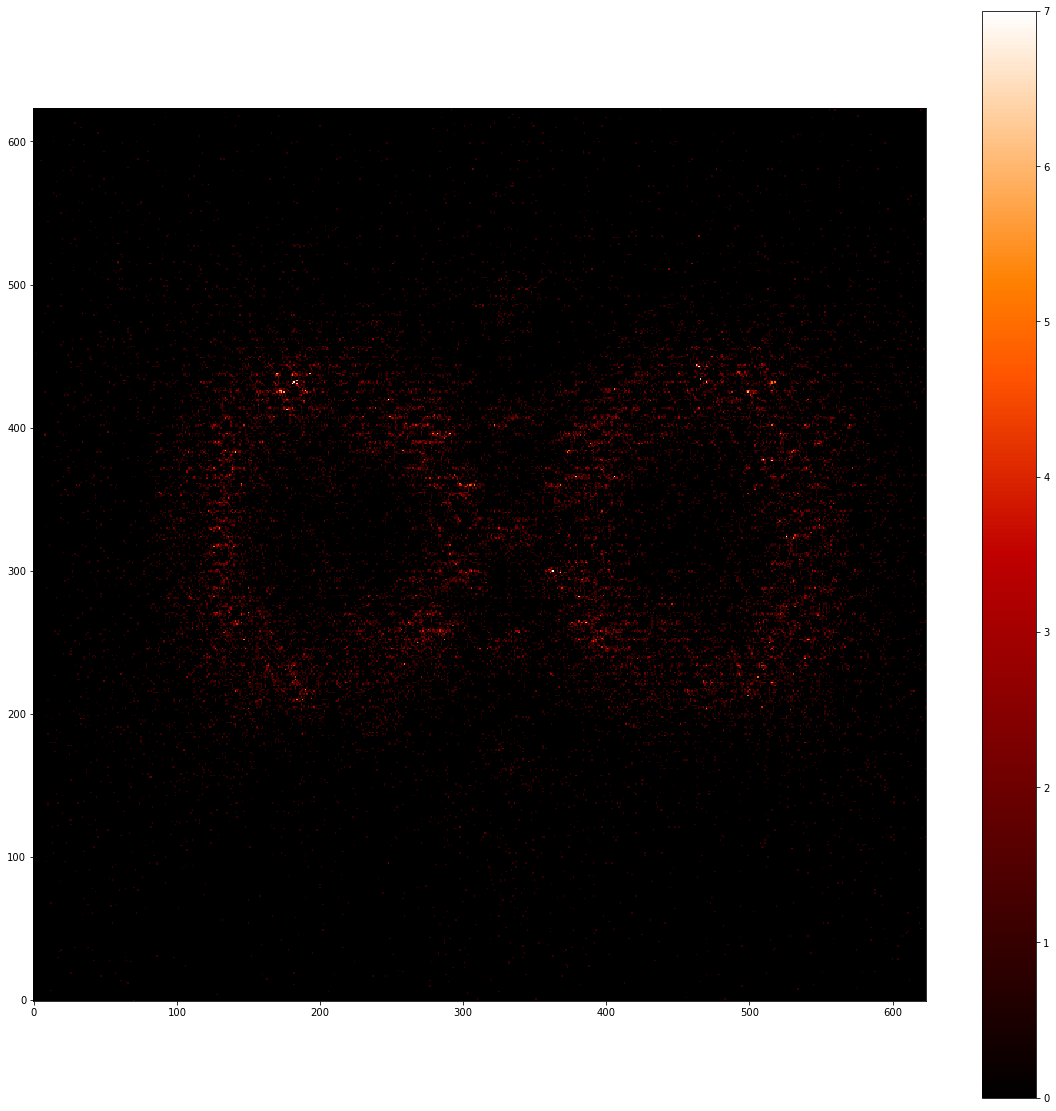

crispy - INFO - Writing data to ../../../crispy/SimResults/testTraps.fits


In [26]:
# loop over columns in which there is a trap
for icol in range(len(traps_X)):
    # determine trap coordinates
    Xval = traps_X[icol]
    Yval = traps_Y[icol]
    # select column below the trap (only part that will be affected by the trap)
    data_column = img.data[:Yval,Xval]
    # flip column vector to accomodate kernel (please be smarter next time and flip kernel instead)
    data_column = data_column[::-1]
    # create a new, empty column with padded edge to accommodate for kernel size
    final = np.zeros(data_column.shape[0]+kernel.shape[0])
    # now do a pseudo-convolution for all pixels in the kernel
    for i in range(len(final)-len(kernel)):
        final[i:i+len(kernel)] += data_column[i]*kernel
    # crop to go back to normal column size
    final = final[:-kernel.shape[0]]
    # and don't forget to flip again because I was stupid
    img.data[:Yval,Xval] = final[::-1]

# we have now created a new flux density map. Now we can draw a Poisson distribution from it.
out = np.random.poisson(img.data)
plt.figure(figsize=(20,20))
plt.imshow(out, cmap='gist_heat')
plt.colorbar()
plt.show()    

Image(data=out).write('../../../crispy/SimResults/testTraps.fits',clobber=True)

## Now with multiple traps along the same column

In [30]:
# we are going to construct 10 kernels for when there are 0-9 traps between a pixel and the register
kernel = np.zeros((10,50))

# kernel size are now 50 pixels instead of 20
arr = np.arange(50) 

# when a pixel has to go through more than one kernel, the exponential constants are added (roughly)
for k in range(kernel.shape[0]):
    if k==0:
        kernel[k,0] = 1 # this is for when there is no traps
    else:
        kernel[k] = np.exp(-0.25/k*arr)
    kernel[k] /= np.sum(kernel[k])


crispy - INFO - Read data from HDU 1 of ../../../crispy/Inputs/os5_spc_064_targetstar_IFS.fits
crispy - INFO - Writing data to ../../../crispy/SimResults/testMultipleTraps_nonoise.fits


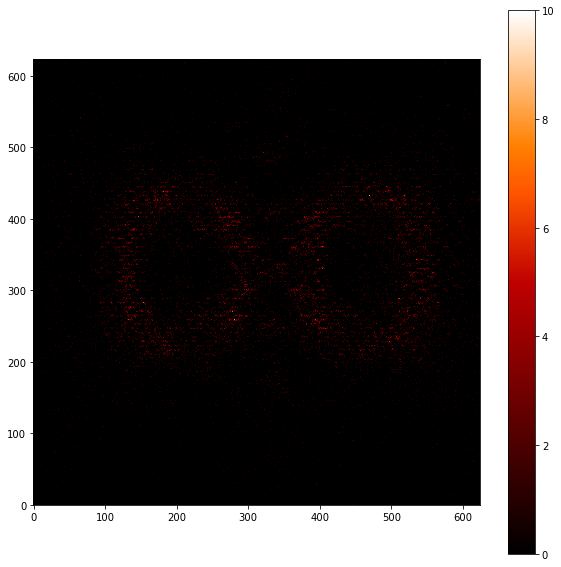

crispy - INFO - Writing data to ../../../crispy/SimResults/testMultipleTraps.fits


In [32]:
# testNoTraps = Image(data=np.random.poisson(img.data))
# testNoTraps.write('../../../crispy/SimResults/testNoTraps.fits',clobber=True)

# reload image from scratch
img = Image('../../../crispy/Inputs/os5_spc_064_targetstar_IFS.fits')
img.data = img.data[200:-200,200:-200]
# just to play with some fluxes for now, the absolute scale is meaningless for this test
img.data*=1000


# copy image so that we don't alter original data
imout = img.data.copy()

# Go over every column instead of every trap
for icol in range(imout.shape[0]):
    Xval = traps_X[icol]
    # how many traps are there between each pixel and the readout register?
    # this returns a 1D array of the same length as the column with the cumulative sum as a function of pixel index
    ntraps = np.cumsum(traps[:,Xval])
    
    # grab the data
    data_column = img.data[:,Xval]
    
    # flip the data since the kernel is still in the wrong direction
    data_column = data_column[::-1]
    
    # create empty column with padding on the ends
    final = np.zeros(data_column.shape[0]+kernel.shape[1])
    
    # loop on all pixels within column
    for i in range(len(final)-(kernel.shape[1])):
        # Add the correct kernel according to how many traps they will pass through
        final[i:i+kernel.shape[1]] += data_column[i]*kernel[ntraps[i].astype(int)]
    
    # crop the column off to get back to the same size
    final = final[:-kernel.shape[1]]
    
    # flip vector
    imout[:,Xval] = final[::-1]

testMultipleTraps = Image(data=imout)
testMultipleTraps.write('../../../crispy/SimResults/testMultipleTraps_nonoise.fits',clobber=True)
    

# add noise
out = np.random.poisson(imout)
plt.figure(figsize=(10,10))
plt.imshow(out, cmap='gist_heat')
plt.colorbar()
plt.show()

testMultipleTraps = Image(data=out)
testMultipleTraps.write('../../../crispy/SimResults/testMultipleTraps.fits',clobber=True)
# import skimage.measure.compare_mse as mse
# import skimage.measure.compare_nrmse as nrmse
# import skimage.measure.compare_ssim as ssim
# s = ssim(testNoTraps.data, testMultipleTraps.data)
# n = nrmse(testNoTraps.data, testMultipleTraps.data)
# m = mse(testNoTraps.data, testMultipleTraps.data)
# print(s,n,m)
# testMultipleTraps.header.append(('comment', ''), end=True)
# testMultipleTraps.header.append(('comment', '*'*60), end=True)
# testMultipleTraps.header.append(('comment', '*'*22 + ' Compare between w/ and w/o traps ' + '*'*20), end=True)
# testMultipleTraps.header.append(('comment', '*'*60), end=True)    
# testMultipleTraps.header.append(('comment', ''), end=True)
# testMultipleTraps.header.append(('SSIM',s,'Structural similarity index'),end=True)
# testMultipleTraps.header.append(('MSE',m,'Mean squared error'),end=True)
# testMultipleTraps.header.append(('NRMSE',m,'Normalized Root Mean squared error'),end=True)


In [ ]:
# def mse(imageA, imageB):
#     # the 'Mean Squared Error' between the two images is the
#     # sum of the squared difference between the two images;
#     # NOTE: the two images must have the same dimension
#     err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
#     err /= float(imageA.shape[0] * imageA.shape[1])

#     # return the MSE, the lower the error, the more "similar"
#     # the two images are
#     return err


# from skimage.measure import structural_similarity as ssim

# def compare_images(imageA, imageB, title):
#     # compute the mean squared error and structural similarity
#     # index for the images
#     m = mse(imageA, imageB)
#     s = ssim(imageA, imageB)

#     # setup the figure
#     fig = plt.figure(title)
#     plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))

#     # show first image
#     ax = fig.add_subplot(1, 2, 1)
#     plt.imshow(imageA, cmap = plt.cm.gray)
#     plt.axis("off")

#     # show the second image
#     ax = fig.add_subplot(1, 2, 2)
#     plt.imshow(imageB, cmap = plt.cm.gray)
#     plt.axis("off")

#     # show the images
#     plt.show()
    
# # img1 = Image('../../code/SimResults/testNoTraps.fits').data
# # img2 = Image('../../code/SimResults/testMultipleTraps.fits').data
# # compare_images(img1,img2,'Traps effects')